# Water potability
# Feature engineering, logical


In [177]:
# General imports
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt


# Import AzureML-Core
from azureml.core import Workspace, Dataset, Datastore

# Register workspace
ws = Workspace.from_config()

# Import dataset from Azure ML
dataset = Dataset.get_by_name(ws, name='water_potability_cleaned')

# Convert to pandas.DataFrame
dfo = dataset.to_pandas_dataframe() # dfo = Original DataFrame import

In [178]:
# Making sure that we have the correct cleaned dataset
dfo.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [179]:
# Create main DataFrame for manipulation
df = dfo.copy()

## Divide feature into features and contents of the water sample

In [180]:
feature = ['ph', 'Hardness', 'Conductivity', 'Turbidity']
contents = ['Solids', 'Chloramines', 'Sulfate', 'Organic_carbon','Trihalomethanes']

## Create column based on contents

In [182]:
df['contents'] = df.loc[:, contents].sum(axis=1)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,contents
0,7.038092,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0,21264.506388
1,3.716080,129.422921,18630.057858,6.635246,333.389426,592.885359,15.180013,56.329076,4.500656,0,19041.591619
2,8.099124,224.236259,19909.541732,9.275884,333.389426,418.606213,16.868637,66.420093,3.055934,0,20335.495771
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,22502.141108
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,18339.224949


## Possible connection between pH and chloramines

In [183]:
df.loc[:, ['ph', 'Chloramines']].describe()

,ph,Chloramines
count,3276.000000,3276.000000
mean,7.076470,7.122277
std,1.464829,1.583085
min,0.227499,0.352000
25%,6.279317,6.127421
50%,7.038092,7.130299
75%,7.870050,8.114887
max,14.000000,13.127000


### Create column of difference between ph and chloramines

In [184]:
df['diff_ph_chloramines'] = np.abs(df.ph - df.Chloramines)

### Distribution of new values

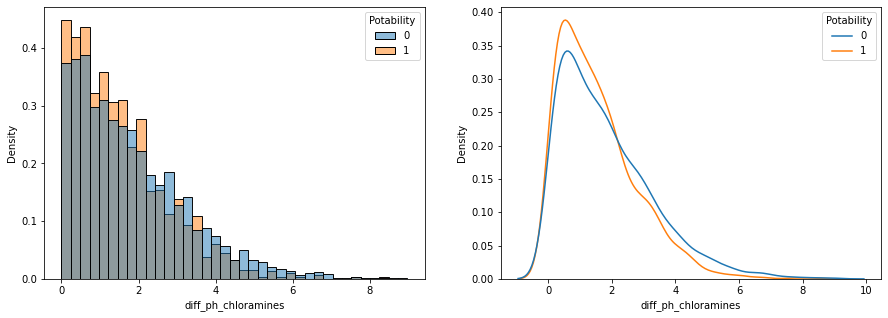

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(ax=ax[0], data=df, x='diff_ph_chloramines', hue='Potability', stat='density', common_norm=False)
sns.kdeplot(ax=ax[1], data=df, x='diff_ph_chloramines', hue='Potability', common_norm=False);

## Create new variables based on difference from mean

In [186]:
df['ph_fixed'] = np.abs(df.ph - 7)
df['chloramines_fixed'] = np.abs(df.Chloramines - 7)
df['turbidity_fixed'] = np.abs(df.Turbidity - 4)

df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,contents,diff_ph_chloramines,ph_fixed,chloramines_fixed,turbidity_fixed
0,7.038092,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0,21264.506388,0.262120,0.038092,0.300212,1.036865
1,3.716080,129.422921,18630.057858,6.635246,333.389426,592.885359,15.180013,56.329076,4.500656,0,19041.591619,2.919166,3.283920,0.364754,0.500656
2,8.099124,224.236259,19909.541732,9.275884,333.389426,418.606213,16.868637,66.420093,3.055934,0,20335.495771,1.176759,1.099124,2.275884,0.944066
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,22502.141108,0.257434,1.316766,1.059332,0.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,18339.224949,2.545623,2.092223,0.453400,0.075075


## Store and upload new dataset

In [192]:
# Save to csv
local_path = 'Data/water_potability_engineered_logical.csv'
df.to_csv(local_path, index=False)

In [193]:
# Upload to Azure
from azureml.core import Datastore
datastore = ws.get_default_datastore()
datastore.upload_files(files=[local_path], target_path='data', overwrite=True)

Uploading an estimated of 1 files
Uploading Data/water_potability_engineered_logical.csv
Uploaded Data/water_potability_engineered_logical.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_9d80e6f4abd548598fb6a783b9ec8114

In [194]:
# Create a dataset and register it
water_potability_engineered_logical = Dataset.Tabular.from_delimited_files(path = [(datastore, "data/water_potability_engineered_logical.csv")])
water_potability_engineered_logical = water_potability_engineered_logical.register(workspace=ws,
                                                            name = 'water_potability_engineered_logical',
                                                            description = 'Logical feature engineering',
                                                            create_new_version=False)

# Feature engineering, brute force

In [11]:
# Create main DataFrame for manipulation
filename = 'Data/water_potability_cleaned.csv'
dfo = pd.read_csv(filename)

df_brute = dfo.copy()

In [12]:
import itertools
liste = df_brute.columns[:-1]
combs = itertools.combinations(liste, 2)


In [13]:
# Loop through possible combinations of features
for c in combs:
    # Difference between two features
    diff = np.abs(df_brute[c[0]] - df_brute[c[1]])

    # Ratio between two features
    ratio = df_brute[c[0]] / df_brute[c[1]] # Ratio between features
    ratio_alt = df_brute[c[1]] / df_brute[c[0]] # Ratio inversed
    
    # Calculate correlation in absolute value
    corr0 = np.abs(np.corrcoef(df_brute.Potability, ratio)[0,1])
    corr1 = np.abs(np.corrcoef(df_brute.Potability, ratio_alt)[0,1])

    # Choose ratio with highest correlation
    if corr1 > corr0:
        ratio = ratio_alt
        name = f'_{c[1]}_{c[0]}'
    else:
        name = f'_{c[0]}_{c[1]}'

    # Assign names
    df_brute[f'ratio{name}'] = ratio
    df_brute[f'diff{name}'] = diff


df_brute.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,...,ratio_Conductivity_Trihalomethanes,diff_Conductivity_Trihalomethanes,ratio_Turbidity_Conductivity,diff_Turbidity_Conductivity,ratio_Trihalomethanes_Organic_carbon,diff_Trihalomethanes_Organic_carbon,ratio_Turbidity_Organic_carbon,diff_Turbidity_Organic_carbon,ratio_Turbidity_Trihalomethanes,diff_Turbidity_Trihalomethanes
0,7.038092,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0,...,6.486980,477.317684,0.005251,561.345519,8.380808,76.611187,0.285472,7.416648,0.034063,84.027835
1,3.716080,129.422921,18630.057858,6.635246,333.389426,592.885359,15.180013,56.329076,4.500656,0,...,10.525388,536.556283,0.007591,588.384703,3.710740,41.149063,0.296486,10.679357,0.079899,51.828420
2,8.099124,224.236259,19909.541732,9.275884,333.389426,418.606213,16.868637,66.420093,3.055934,0,...,6.302403,352.186121,0.007300,415.550279,3.937490,49.551456,0.181161,13.812703,0.046009,63.364159
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,...,3.620296,262.924842,0.012742,358.637746,5.442548,81.905150,0.251065,13.807754,0.046130,95.712904
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,...,12.451119,366.412821,0.010228,394.335738,2.768404,20.439713,0.352568,7.483204,0.127354,27.922917


In [16]:
# Correlation object
corr_brute = df_brute.corr(method = 'pearson')
mask = abs(corr_brute.Potability).sort_values(ascending=False) < 0.01

mask[0] = True
df_brute = df_brute.loc[:, mask]

<AxesSubplot:>

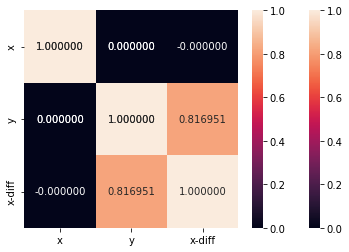

In [207]:

y = np.array([1]*60)
y[20:40] = 0
x = np.linspace(30,70,60)
dft = pd.DataFrame(data={'x': x, 'y': y})
dft.plot.scatter(x='x', y='y')
sns.heatmap(dft.corr(method='pearson'), annot=True, fmt='f')
dft['x-diff'] = abs(dft.x - dft.x.mean())
sns.heatmap(dft.corr(method='pearson'), annot=True, fmt='f')

In [9]:
df_brute.to_csv('Data/water_potability_engineered_brute.csv', index=False)